In [16]:
from vit_keras import vit
import tensorflow as tf
from typing import *
from tqdm import tqdm

In [17]:
CFG_SEED=71
NUM_EPOCHS = 30
fine_tune_at = 16

In [18]:
vit_model = vit.vit_b16(
        image_size=224,
        activation='softmax',
        pretrained=True,
        include_top=False,
        pretrained_top=False,
        classes=44)

for layer in vit_model.layers:
    layer.trainable = False


c:\Users\jagar\anaconda3\envs\DeepLearning\lib\site-packages\vit_keras\utils.py:81: UserWarning: Resizing position embeddings from 24, 24 to 14, 14
  warnings.warn(


In [19]:
initializer = tf.keras.initializers.GlorotNormal(seed=CFG_SEED)
early_stoppage = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', patience=4)

In [20]:
def vit_b16_model():    
    vit_b16_sequential = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(224,224,3), dtype=tf.float32, name='input_image'),
        vit_model,
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(512, activation='relu'),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(44, dtype=tf.float32, activation='softmax')
    ], name='vit_b16_sequential_model')
    
    return vit_b16_sequential

In [21]:
# Generate Model
model_vit_b16 = vit_b16_model()

# Generate Summary of the Model
model_vit_b16.summary()

Model: "vit_b16_sequential_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b16 (Functional)        (None, 768)               85798656  
                                                                 
 dropout_1 (Dropout)         (None, 768)               0         
                                                                 
 dense_3 (Dense)             (None, 512)               393728    
                                                                 
 dense_4 (Dense)             (None, 256)               131328    
                                                                 
 dense_5 (Dense)             (None, 44)                11308     
                                                                 
Total params: 86,335,020
Trainable params: 536,364
Non-trainable params: 85,798,656
_________________________________________________________________


In [22]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    directory='training_data/',
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(224, 224))


validation_ds = tf.keras.utils.image_dataset_from_directory(
    directory='validation_data/',
    labels='inferred',
    label_mode='categorical',
    batch_size=32,
    image_size=(224, 224))

Found 3581 files belonging to 44 classes.
Found 895 files belonging to 44 classes.


In [23]:
val_batches = tf.data.experimental.cardinality(validation_ds)
print('Number of val batches: %d' % val_batches)
test_dataset = validation_ds.take(val_batches // 5)
validation_data = validation_ds.skip(val_batches // 5)

Number of val batches: 28


In [24]:
augmentation_layer = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip(mode="horizontal"),
        tf.keras.layers.RandomZoom(0.1)
    ], name='augmentation_layer'
)

In [25]:
normalization_layer = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (augmentation_layer(vit.preprocess_inputs(x)), y)) # Where x—images, y—labels.
val_ds = validation_data.map(lambda x, y: (augmentation_layer(vit.preprocess_inputs(x)), y)) # Where x—images, y—labels.
test_ds = test_dataset.map(lambda x, y: (augmentation_layer(vit.preprocess_inputs(x)), y)) # Where x—images, y—labels.

In [27]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)

In [28]:
tf.random.set_seed(CFG_SEED)

# Compile the model
model_vit_b16.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    # loss = tf.keras.losses.BinaryCrossentropy(),

    optimizer=tf.keras.optimizers.Adam(learning_rate=0.004),
    # optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),
    metrics=['accuracy']
)


history = model_vit_b16.fit(train_ds,validation_data=val_ds, epochs=NUM_EPOCHS, callbacks=[early_stoppage])
print(model_vit_b16.evaluate(test_ds))

Epoch 1/30
112/112 [==============================] - 612s 5s/step - loss: 2.6641 - accuracy: 0.2935 - val_loss: 2.0946 - val_accuracy: 0.4245
Epoch 2/30
112/112 [==============================] - 630s 6s/step - loss: 1.8071 - accuracy: 0.4848 - val_loss: 1.6341 - val_accuracy: 0.5401
Epoch 3/30
112/112 [==============================] - 632s 6s/step - loss: 1.4953 - accuracy: 0.5616 - val_loss: 1.4918 - val_accuracy: 0.5619
Epoch 4/30
112/112 [==============================] - 684s 6s/step - loss: 1.3247 - accuracy: 0.5998 - val_loss: 1.4244 - val_accuracy: 0.5578
Epoch 5/30
112/112 [==============================] - 710s 6s/step - loss: 1.1981 - accuracy: 0.6353 - val_loss: 1.3477 - val_accuracy: 0.6082
Epoch 6/30
112/112 [==============================] - 664s 6s/step - loss: 1.0873 - accuracy: 0.6638 - val_loss: 1.2330 - val_accuracy: 0.6395
Epoch 7/30
112/112 [==============================] - 688s 6s/step - loss: 1.0361 - accuracy: 0.6833 - val_loss: 1.1894 - val_accuracy: 0.6395

In [29]:
# ## 2 EPOCHS TRAINING: 
#Epoch 1/2
# 112/112 [==============================] - 2820s 25s/step - loss: 2.5552 - accuracy: 0.3250 - val_loss: 1.9654 - val_accuracy: 0.4395
# Epoch 2/2
# 112/112 [==============================] - 2754s 25s/step - loss: 1.6741 - accuracy: 0.5035 - val_loss: 1.5377 - val_accuracy: 0.5401
# 1/5 [=====>........................] - ETA: 1:13 - loss: 1.6646 - accuracy: 0.4375


#5/5 [==============================] - 98s 20s/step - loss: 1.7411 - accuracy: 0.4500
# [1.7410808801651, 0.44999998807907104]

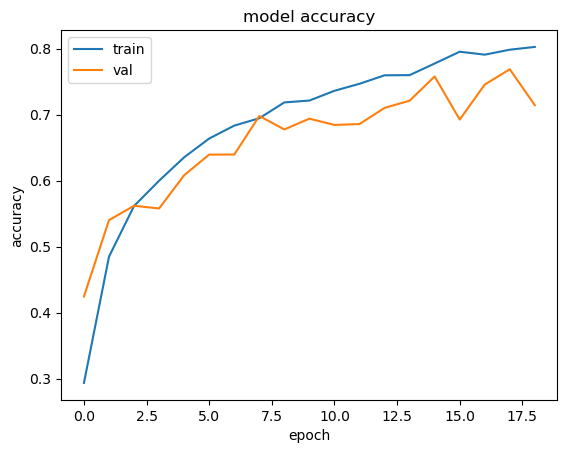

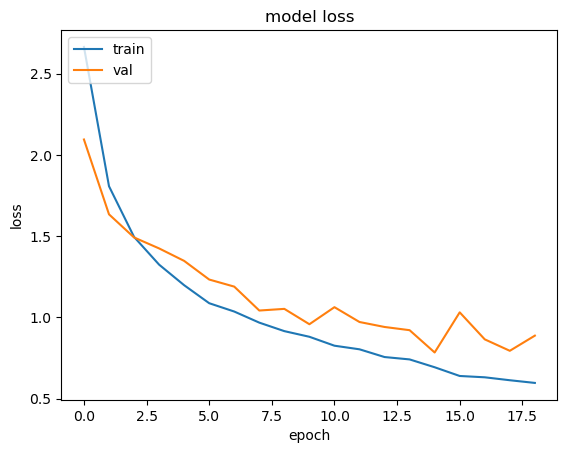

In [30]:
from matplotlib import pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('accuracy.png')
plt.show()


plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig('loss.png')
plt.show()